In [1]:
# Trying a DenseNet
# Based off DenseNet-121 in Table 1,
# Densely Connected CNNs, Huang et. al.

# Use CIFAR-10 image database
import torch
import torchvision
import torchvision.transforms as transforms

# Normalize image pixel values from range [0, 1] to range [-1, 1]
# (from tutorial)
# TODO: normalize by channel mean and standard dev.
#       - can use torch.mean(input, 0) to get mean value of each channel,
#         and torch.std(input, 0) to get stand. dev. of each channel
#         (make sure 0 is the right dimension)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True,
                                          num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False,
                                         num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


Files already downloaded and verified


size:  torch.Size([3, 70, 274])
channels:  3
 deer  ship   cat  bird


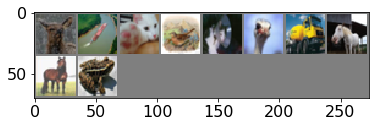

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    print('size: ', img.size())
    print('channels: ', img.size()[0])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #axes 1, 2, 0

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images with labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# TODO: fix so only 4 images show


In [30]:
# Create the DenseNet

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class DenseNetTest(nn.Module):
    def __init__(self, k=4, k0=16, L=4, num_blocks=3, layers=None):
        """
        Creates DenseNet with:
         - growth rate k,
         - k0 number of input channels in the input layer to the first dense block,
         - layers per block L,
         - num_blocks dense blocks
        Note: Growth-rate = number of output feature maps from each H_l,
        where H_l is the non-linear transformation within dense blocks
        """

        super(DenseNetTest, self).__init__()
        self.k = k
        self.k0 = k0
        self.L = L
        self.num_blocks = num_blocks

        # Keep layers in a list, then convert to a sequence at the end
        # (since PyTorch doesn't support appending to a nn.Sequential)
        layers = []

        # Initial convolution layer before first dense block
        layers.extend([nn.ZeroPad2d(1),
                       nn.Conv2d(in_channels=3,
                                 out_channels=16,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1)
        ])

        self.layers = layers
        self.seq = nn.Sequential(*layers)

        def bottleneck(x, input_channels):
            """
            BN-ReLU-1x1 conv layer
            x: input tensor
            input_channels: the number of input channels,
            Produces 4k output feature maps
            """
            bottleneck_sequence = nn.Sequential(
                nn.BatchNorm2d(input_channels),
                nn.ReLU(),
                nn.Conv2d(input_channels, 4*k, kernel_size=1, stride=1)
            )
            return bottleneck_sequence(x)

        def H_l(x, input_channels):
            """
            Bottleneck-BN-ReLU-3x3 conv
            x: input tensor
            input_channels: number of input channels,
            """
            h_l_sequence = nn.Sequential(
                bottleneck(input_channels, k),
                nn.BatchNorm2d(4*k),
                nn.ReLU(),
                nn.Conv2d(4*k, k0 + k*(l-1), kernel_size=3, stride=1, padding=1)
            )
            return h_l_sequence(x)

        def transition(x, input_channels):
            """
            BN-ReLU-1x1 conv-2x2 average pooling, to be done at the end of
            each dense block
            x: input tensor
            input_channels: number of input channels
            """
            trans_sequence = nn.Sequential(
                nn.BatchNorm2d(input_channels),
                nn.ReLU(),
                nn.Conv2d(input_channels, 4*k, kernel_size=1, stride=1),
                nn.AvgPool2d(2)
            )
            return trans_sequence(x)

        self.H_l = H_l
        self.bottleneck = bottleneck
        self.transition = transition


    def forward(self, x):
        acc_input = x       # accumulated input tensor
        for d in range(self.num_blocks):
            for l in range(self.L):
                # Form a dense block
               if x.dim() != 4:
                   # dimensions should be [batch, channels, height, width]
                   raise Exception('Not a 4-dimensional tensor')


               num_channels = acc_input.size()[1]
               # TODO: check that the above gives the correct number of channels

               output = self.H_l(acc_input, num_channels)
               acc_input = torch.cat((acc_input, output), dim=1)
               return acc_input



In [31]:
net = DenseNetTest(k=3, L=3)
print(net)



DenseNetTest(
  (seq): Sequential(
    (0): ZeroPad2d((1, 1, 1, 1))
    (1): Conv2d (3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)


In [32]:
# Training
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# TODO: tune SGD lr, check that params work, look up momemtum


In [33]:
# Feed training set through network

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data

        # wrap inputs in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/2000.0))
            running_loss = 0.0

print('Finished training')

AttributeError: 'int' object has no attribute 'size'